In [35]:
%matplotlib inline
import scipy as sp
import pandas as pd
import numpy as np
import random as rdm
import seaborn as sns
import math
import re
import bs4
import matplotlib.pyplot as plt
import geopandas as gpd
import bs4
import dateparser

## Traitement du corpus Europresse

Ensemble des articles Europresse requête "France médecine génomique"

Chargement du corpus

In [109]:
corpus_html = bs4.BeautifulSoup(open("DATA/corpus_europrese_FMG2025.HTML"),"lxml")

In [110]:
#Mettre en forme le corpus en cherchant les champs qui nous intéressent
corpus = []
for i in corpus_html.find_all("article"):
    try:
        titre = i.find("div",{"class":"titreArticle"}).text
    except:
        titre = None
    try:
        header = i.find("span",{"class":"DocHeader"}).text
    except:
        header = None
    try:
        publication = i.find("span",{"class":"DocPublicationName"}).text
    except:
        publication = None
    try:
        text = i.find("div",{"class":"DocText clearfix"}).text
    except:
        text = None
    corpus.append([header,titre,publication,text])

In [111]:
corpus = pd.DataFrame(corpus) #passer en format Panda
corpus.columns = ["Date","Titre","Journal","Contenu"]

Sortie du document pour codage

In [112]:
corpus[["Date","Titre","Journal"]].to_excel("DATA/europresse_codage.xlsx")

## Traitement du fichier Europresse recodé

Chargement du fichier

In [78]:
data = pd.read_excel("DATA/europresse_codage-completed.xlsx")
data[0:3]

,Date,Titre,Journal,Pertinence,"Soin, Patients, système de santé, santé publique","Economie, industrie, financement, coûts",Lieu,"Politique, Gouvernement",International,Innovation,Recherche Médicale,"Autres Pathologies : rares, communes, cardiovasculaires et neurodégénératives",cancer,"Médecine de Précision, Personnalisée, génomique","Biostatistique, big data, analyse de données",Ethique,Unnamed: 16
0,2017-11-30,"Le numéro 1 du séquençage de l'ADN lance un ""...",La Tribune,1,non,oui,Evry,oui,oui,oui,non,non,non,oui,non,non,NaN
1,2016-12-19,Plan France médecine génomique 2025 Pour u...,Le Quotidien du Médecin,3,oui,oui,non,oui,oui,oui,oui,oui,oui,oui,oui,oui,NaN
2,2017-09-18,Sélection du projet SeqOIA porté par l'Assist...,NewsPress,2,oui,oui,Ile-de-France,non,non,non,oui,oui,oui,oui,oui,non,NaN


Traitements

In [58]:
data["Journal"].str.strip().value_counts()[0:10]

Le Quotidien du Médecin    12
AFP Infos Françaises        8
Boursier                    8
La Tribune                  7
Biotech.Info 3.0            7
Bulletin Quotidien          6
Ouest-France                5
NewsPress                   5
Actu Labo                   4
Le Figaro                   3
Name: Journal, dtype: int64

In [59]:
data["Pertinence"].value_counts()

1    78
3    21
0    12
2     9
Name: Pertinence, dtype: int64

On écarte les cas non pertinents (0)

In [80]:
data = data[data["Pertinence"]!=0]

Evolution dans le temps

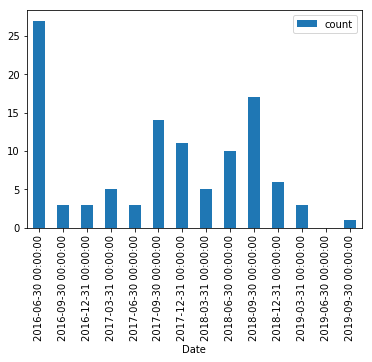

In [97]:
data["count"]=1
ax = data[["Date","count"]].set_index("Date").resample("3M").sum().plot(kind="bar")

### Traitements des variables

In [98]:
data["Soin, Patients, système de santé, santé publique"].value_counts()

non    58
oui    50
Name: Soin, Patients, système de santé, santé publique, dtype: int64

In [99]:
data["Economie, industrie, financement, coûts"].value_counts()

oui    66
non    42
Name: Economie, industrie, financement, coûts, dtype: int64

In [100]:
data["Politique, Gouvernement"].value_counts()

non    58
oui    48
Name: Politique, Gouvernement, dtype: int64

In [101]:
data["Innovation"].value_counts()

non    91
oui    17
Name: Innovation, dtype: int64

In [102]:
data["Recherche Médicale"].value_counts()

oui    86
non    22
Name: Recherche Médicale, dtype: int64

In [103]:
data["cancer"].value_counts()

oui    61
non    47
Name: cancer, dtype: int64

In [104]:
data["Médecine de Précision, Personnalisée, génomique"].value_counts()

oui    55
non    53
Name: Médecine de Précision, Personnalisée, génomique, dtype: int64

### Tableaux croisés

In [106]:
pd.crosstab(data["cancer"],data["Soin, Patients, système de santé, santé publique"])

"Soin, Patients, système de santé, santé publique",non,oui
cancer,,
non,27,20
oui,31,30


In [107]:
pd.crosstab(data["cancer"],data["Innovation"])

Innovation,non,oui
cancer,,
non,41,6
oui,50,11


In [108]:
pd.crosstab(data["cancer"],data["Economie, industrie, financement, coûts"])

"Economie, industrie, financement, coûts",non,oui
cancer,,
non,23,24
oui,19,42


## Générer un fichier Iramuteq

In [156]:
with open("DATA/sortie-ira-europresse.txt","w") as f:
    for i,j in data.join(corpus["Contenu"]).iterrows():
        f.write("**** *id_%d *pertinence_%d *soin_%s *economie_%s *cancer_%s *recherchem_%s annee_%d \n\n"
                % (i,j["Pertinence"],j["Soin, Patients, système de santé, santé publique"],
                   j["Economie, industrie, financement, coûts"],
                   j["cancer"],
                   j["Recherche Médicale"],
                   j["Date"].year
                   ))
        f.write(j["Titre"]+"\n")
        f.write(j["Contenu"].replace("*"," ")+"\n\n")
